In [1]:
import numpy as np
import time as t
import pickle
from IPython.display import clear_output
from scipy.stats import norm
import matplotlib.pyplot as plt

from sbi.inference import SNPE
import sbi.utils as utils
from sbi.analysis import pairplot

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

from Chempy.parameter import ModelParameters

/Users/bguenes/miniconda3/envs/master_chempy_multi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load & prepare the data

In [2]:
# ------ Load & prepare the data ------

# --- Load in training data ---
path_training = '../ChempyMulti/tutorial_data/TNG_Training_Data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = '../ChempyMulti/tutorial_data/TNG_Test_Data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
def clean_data(x, y):
    # Remove all zeros from the data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)

"""
# --- Normalize the data ---
x_mean, x_std = train_x.mean(axis=0), train_x.std(axis=0)
y_mean, y_std = train_y.mean(axis=0), train_y.std(axis=0)


def normalize_data(x, y, x_mean=x_mean, x_std=x_std, y_mean=y_mean, y_std=y_std):
    x = (x - x_mean) / x_std
    y = (y - y_mean) / y_std

    return x, y


train_x, train_y = normalize_data(train_x, train_y)
val_x, val_y     = normalize_data(val_x, val_y)
"""

train_x = torch.tensor(train_x).float()
train_y = torch.tensor(train_y).float()
val_x = torch.tensor(val_x).float()
val_y = torch.tensor(val_y).float()

# Setup the priors

In [3]:
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

# Train the posterior

In [4]:
#inference = SNPE(prior=combined_priors)

In [5]:
"""
start = t.time()
density_estimator = inference.append_simulations(train_x, train_y).train()
posterior = inference.build_posterior(density_estimator)
end = t.time()
comp_time = end - start
print(f'Time taken to train the posterior with {len(train_y)} samples: '
      f'{np.floor(comp_time/60).astype("int")}min {np.floor(comp_time%60).astype("int")}s')
"""

'\nstart = t.time()\ndensity_estimator = inference.append_simulations(train_x, train_y).train()\nposterior = inference.build_posterior(density_estimator)\nend = t.time()\ncomp_time = end - start\nprint(f\'Time taken to train the posterior with {len(train_y)} samples: \'\n      f\'{np.floor(comp_time/60).astype("int")}min {np.floor(comp_time%60).astype("int")}s\')\n'

In [6]:
#with open("data/posterior_SNPE_chempy.pickle", "wb") as f:
#    pickle.dump(posterior, f)

# Test the posterior

In [8]:
with open("data/posterior_sbi.pickle", "rb") as f:
    posterior = pickle.load(f)

Index: 32742
x: tensor([-1.7217, -2.1700, -0.2470,  0.4639,  0.2588, 11.0340])


Drawing 10000 posterior samples: 12010it [00:02, 5295.76it/s]                          


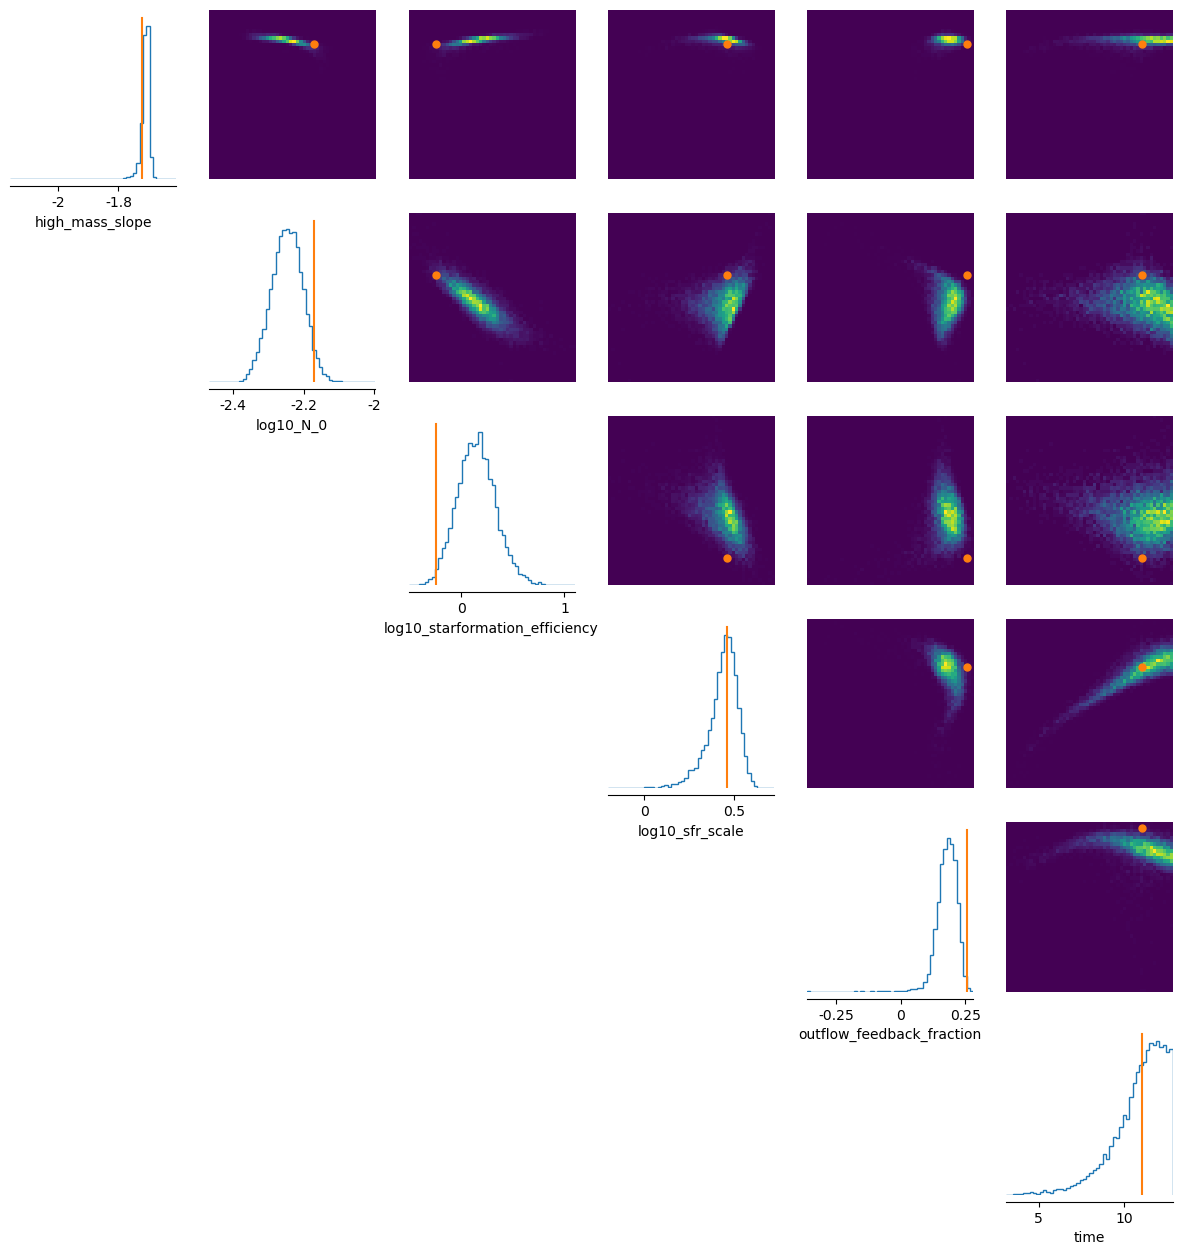

In [9]:
# pick a random point from the validation data
index = np.random.randint(0, len(val_x))
x = val_x[index]
y = val_y[index]

print(f'Index: {index}')
print(f'x: {x}')
# sample 10000 points from the posterior
posterior_samples = posterior.sample((10000,), x=y)
# plot the posterior samples
_ = pairplot(posterior_samples, figsize=(15, 15), points=x, labels=labels)


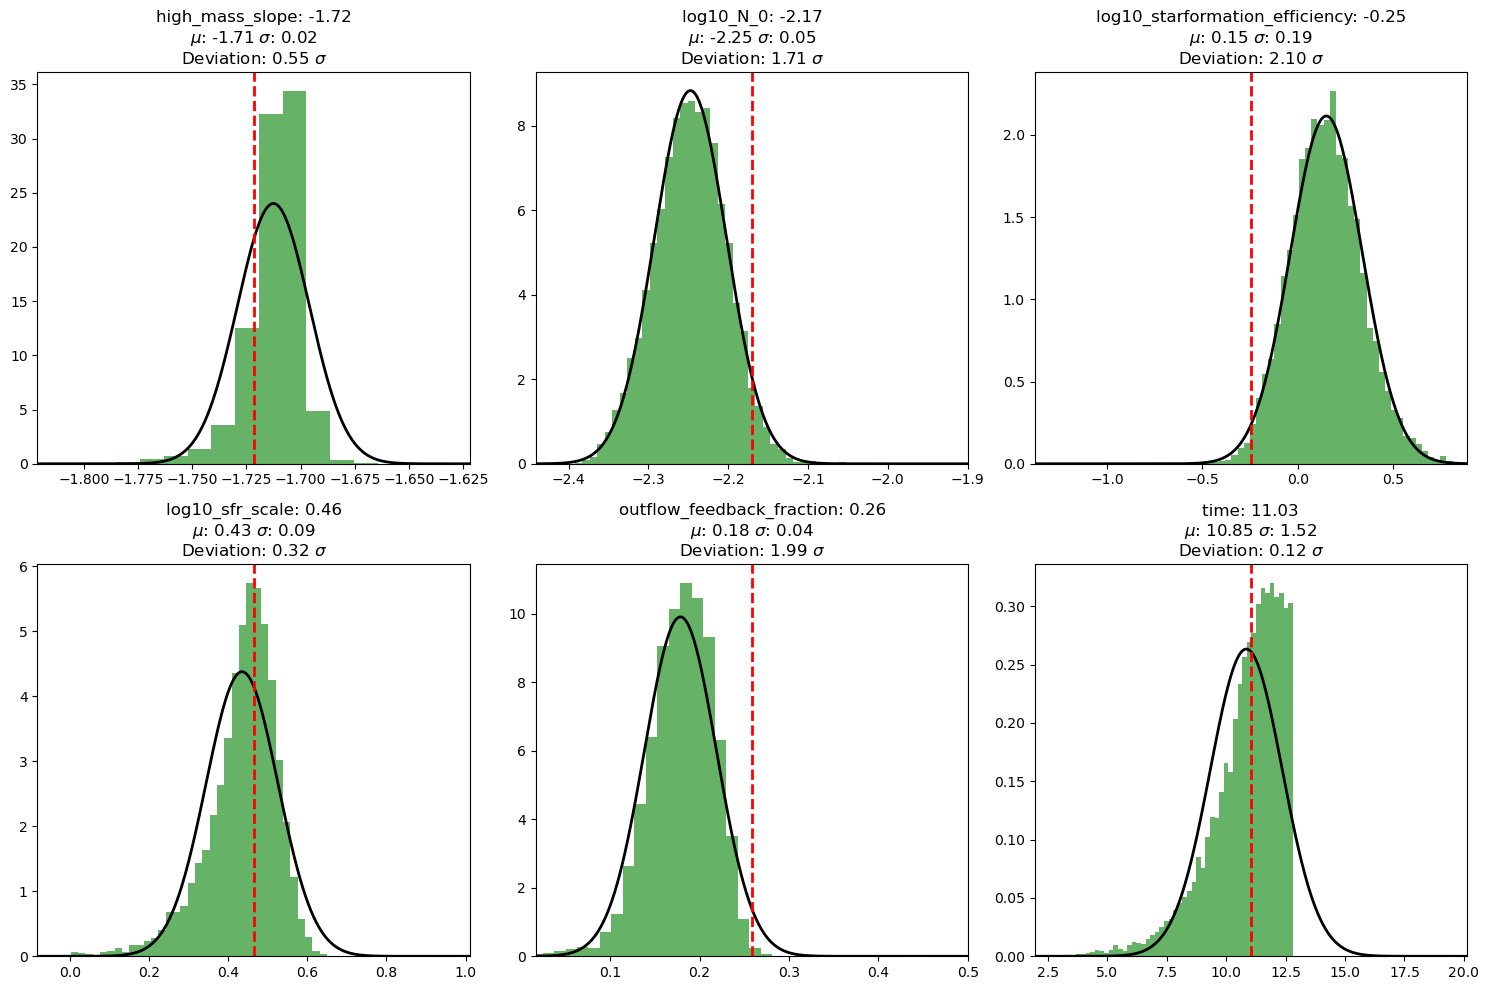

In [18]:
fig, ax = plt.subplots(2,3, figsize=(15, 10))

for i in range(6):
    
    (mu, sigma) = norm.fit(posterior_samples.numpy().T[i])
    true_value = val_x[index][i].numpy()

    x_min = true_value - 6*sigma
    x_max = true_value + 6*sigma

    deviation = abs(true_value - mu) / sigma
    
    ax[i//3, i%3].hist(posterior_samples.numpy().T[i], bins=50, density=True, alpha=0.6, color='g')
    #xmin, xmax = ax[i//3, i%3].get_xlim()
    x = np.linspace(x_min, x_max, 1000)
    p = norm.pdf(x, mu, sigma)
    ax[i//3, i%3].set_xlim(x_min, x_max)
    ax[i//3, i%3].plot(x, p, 'k', linewidth=2)
    ax[i//3, i%3].axvline(x=true_value, color='r', linestyle='dashed', linewidth=2)
    
    ax[i//3, i%3].set_title(fr"{labels[i]}: {true_value:.2f}"
                            "\n"
                            fr"$\mu$: {mu:.2f} $\sigma$: {sigma:.2f}"
                            "\n"
                            fr"Deviation: {deviation:.2f} $\sigma$")
    
plt.tight_layout()
plt.show()

In [11]:
print("Priors:")
for i in range(len(priors)):
    print(fr'{labels[i]}: {priors[i][0].item():.2f} +/- {priors[i][1].item():.2f}')

Priors:
high_mass_slope: -2.30 +/- 0.30
log10_N_0: -2.89 +/- 0.30
log10_starformation_efficiency: -0.30 +/- 0.30
log10_sfr_scale: 0.55 +/- 0.10
outflow_feedback_fraction: 0.50 +/- 0.10
